### Packages:

In [22]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
from datetime import date 
from random import randint
import matplotlib.pyplot as plt

### Functions:


In [2]:
def extract_fpts(values_str):
    """
    Converts string of fpts to a list that can be indexed
    """
    index_list = [0]
    for i in range(len(values_str)):
        if values_str[i] == '.':
            index_list.append(i + 2)
            
    values_list = []
    for i in range(len(index_list) - 1):
        value = float(values_str[index_list[i] : index_list[i + 1]])
        values_list.append(value)
        
    return values_list

In [3]:
def extract_table(position):
    """
    Extracts table on url for user inputted position
    """
    url_base = 'https://www.fantasypros.com/nfl/projections/BASE.php?max-yes=true&min-yes=true&week=draft'
    url = url_base.replace('BASE', position)
    r = requests.post(str(url))
    soup = BeautifulSoup(r.text)

    ladle_of_soup = soup.find('div', attrs={'class' : 'mobile-table'})
    table = ladle_of_soup.find('table', attrs={'id' : 'data'})
    table_body = table.find('tbody')

    df = pd.DataFrame()
    
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        for j in range(len(cols)):
            col = cols[j]
            if j == 0:
                player_info = col.text.split(' ')
                if position != 'dst':
                    name = ' '.join(player_info[:-2]).strip()
                    team = player_info[-2].strip()
                else:
                    name = ' '.join(player_info[:-1]).strip()
                    team = ''
            elif j == (len(cols) - 1):
                values_str = col.text
                values_list = extract_fpts(values_str)
        row = {'name' : name, 'team' : team, 'position' : position,
               'median_fpts' : values_list[0], 'high_fpts' : values_list[1], 'low_fpts' : values_list[2]}

        df = df.append(pd.DataFrame(row, index = [0]), ignore_index = True)
    return df

### List of tables

In [4]:
tables = ['qb', 'rb', 'wr', 'te', 'flex', 'k', 'dst']

### Create combined tables

Known issues:
 - dst tables does not have the 3 letter abbreviation for each team

In [5]:
df = pd.DataFrame()
for position in tables:
    df_position = extract_table(position)
    df = pd.concat((df, df_position), ignore_index = True)

In [28]:
df.groupby('position')['median_fpts'].describe()

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
dst,32.0,101.365625,9.051773,83.1,95.625,104.45,105.225,117.0
flex,581.0,49.138210,58.698242,0.1,5.200,21.70,78.500,301.4
k,35.0,116.031429,22.222018,0.0,113.100,120.80,124.600,139.8
qb,95.0,103.197895,129.070330,0.0,4.700,10.70,242.750,379.6
rb,174.0,62.009770,72.120873,0.1,7.075,34.85,96.675,301.4
te,142.0,32.202817,36.872550,0.7,6.375,18.20,47.150,199.3
wr,265.0,49.761509,56.312705,0.7,2.900,21.90,86.100,229.0


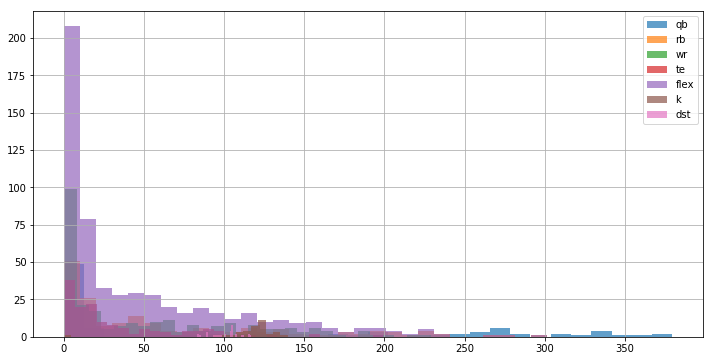

In [25]:
for i in df['position'].unique():
    df_temp = df[df['position'] == i].copy()
    df_temp['median_fpts'].hist(bins = 30, alpha = 0.7, figsize = (12,6), label = i)
    plt.legend()
plt.show()